In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import networkx as nx

import torch 

In [2]:
fnames = ['Mbd3_mean', 
          'WT_CTCF_mean', 
          'KO_CTCF_mean', 
          'WT_Smc3_mean',
          'KO_Smc3_mean', 
          '0h_H3K27ac_mean', 
          '1h_H3K27ac_mean',
          '24h_H3K27ac_mean', 
          '48h_H3K27ac_mean', 
          'WT_Nanog_mean',
          'KO_Nanog_mean', 
          'WT_Klf4_mean', 
          'KO_Klf4_mean', 
          '0h_H3K4me3_mean',
          '24h_H3K4me3_mean', 
          'KO_Chd4_mean', 
          '24h_Chd4_mean', 
          '48h_Chd4_mean']

In [3]:
def torch_to_nx(arch, fnames= fnames):
    G = nx.Graph()
    G.add_nodes_from([(idx, 
                     {fnames[jdx]: arch.x.numpy()[idx,jdx] for jdx in np.arange(len(fnames))
                     }
                     ) for idx in np.arange(arch.x.numpy().shape[0])
                     ]
                   )
    G.add_edges_from([(arch.edge_index.numpy()[0,idx],
                       arch.edge_index.numpy()[1,idx],
                     {'KO_weight': arch.edge_attr.numpy()[idx,0]-arch.edge_attr.numpy()[idx,1],
                      'WT_weight': arch.edge_attr.numpy()[idx,0]+arch.edge_attr.numpy()[idx,1]}
                     ) for idx in np.arange(arch.edge_index.numpy().shape[1])
                     ])
    
    return G, arch.name

In [23]:
def symlog(vec):
    out = vec.copy()
    out[vec>1]=1+np.log(out[vec>1])

    return out

def draw_graph(G,
               ax, 
               weight = 'WT_weight',
               color_nodes_by = 'Mbd3',
               node_cmap = 'Blues',
               edge_cmap = 'Reds',
               log_node_color = True,
               log_edge_weight = True
               ):
    #remove self loops for visualisation purposes   
    G.remove_edges_from(nx.selfloop_edges(G))
    
    pos = nx.spring_layout(G, weight = weight)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist = [25],
                           node_size = 500,
                           node_color = 'red',
                           ax = ax
                           )

    node_cols = np.array([G.nodes[node][color_nodes_by] for node in G.nodes()])
    if log_node_color:
        node_cols = symlog(node_cols)
    
    
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color=node_cols,
                           cmap = node_cmap,
                           node_size = 150,
                           ax = ax
                           )
    
    
    edge_weights = np.array([G[edge[0]][edge[1]][weight] for edge in G.edges()])
    if log_edge_weight:
        edge_weights = symlog(edge_weights)

    nx.draw_networkx_edges(G,
                           pos,
                           edge_color = edge_weights,
                           edge_cmap = plt.cm.Greys,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    nx.draw_networkx_edges(G,
                           pos,
                           edgelist = [edge for edge in G.edges() if abs(edge[0]-edge[1])==1],
                           edge_color = 'red',
                           width = 2,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )

In [24]:
DATASET = "tutorial_data/500examplegraphs_18features_500kb_rnaseqtarget.pt"
dset = torch.load(DATASET)

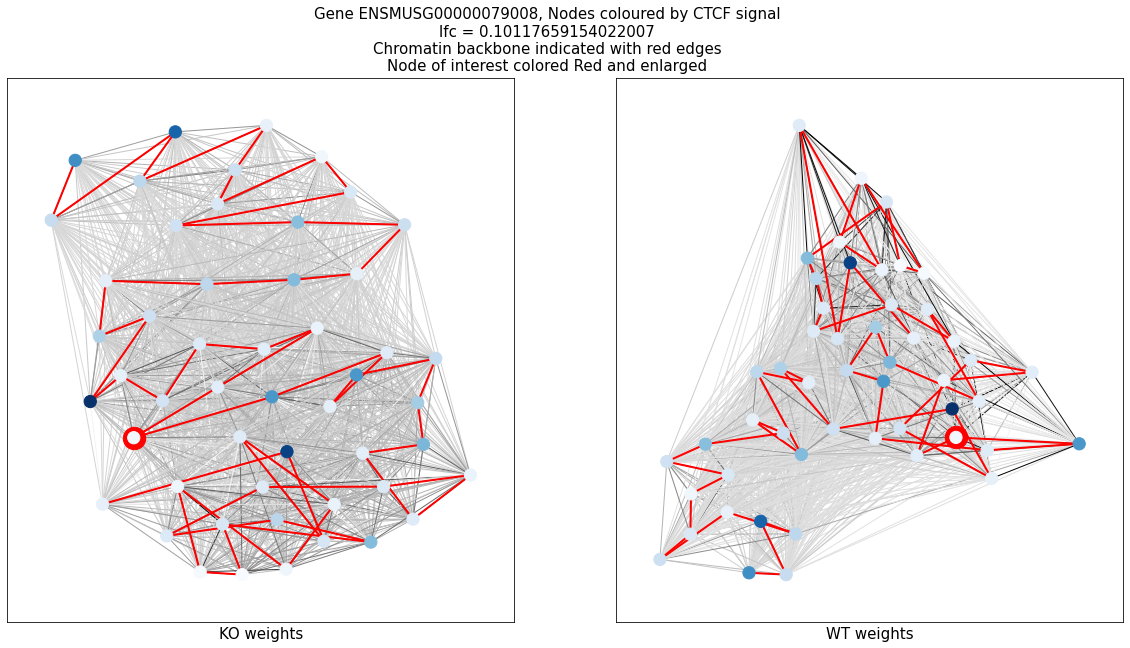

In [25]:
fig,ax = plt.subplots(1,2, figsize = (20,10))
node_col_WT = 'WT_CTCF_mean'
node_col_KO = 'KO_CTCF_mean'
idx = 50

dat,name = torch_to_nx(dset[idx])
draw_graph(dat,
           ax[1],
           color_nodes_by=node_col_WT,
           weight = 'WT_weight',
           log_edge_weight = True
          )
ax[1].set_xlabel("WT weights", size = 15)

draw_graph(dat,
           ax[0],
           color_nodes_by=node_col_WT,
           weight = 'KO_weight',
           log_edge_weight = True
          )
ax[0].set_xlabel("KO weights", size = 15)

title = fig.suptitle(f"Gene {name}, Nodes coloured by CTCF signal\nlfc = {dset[idx].y}\nChromatin backbone indicated with red edges\nNode of interest colored Red and enlarged",
         size = 15)